In [3]:
import MDAnalysis as mda
import MDAnalysis.transformations as trans
import matplotlib.pyplot as plt
from MDAnalysis.lib.distances import capped_distance
import numpy as np
from scipy.constants import Avogadro
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = 'Arial'

# calculate distance between solution molecules and functional groups
def counts_env(molecule, target_atoms):
    mol_com = molecule.center_of_mass(compound='residues')
    indices, distances = capped_distance(target_atoms, mol_com, max_cutoff=7.5, box=u.dimensions)
    mol_threshold = len(indices)
    return mol_threshold

def avg_mol(mol_counts):
    return np.mean(mol_counts)

# read trajectory file
u = mda.Universe('../traj/npt_1.tpr', '../traj/traj.xtc')
transforms = [trans.unwrap(u.atoms)]
u.trajectory.add_transformations(*transforms)

# calculate the center of mass for functional groups
def get_target_atoms(label):
    if label == "S-Main":
        return u.select_atoms("resname PT* and name S2")
    elif label == "S-Side":
        return u.select_atoms("resname PT* and name S1 S3")
    elif label == "2O":        
        return u.select_atoms("resname P2O and name O3 O4")
    elif label == "DBZ-SO2":
        sulfone1 = u.select_atoms("resname PT* and name S5 O3 O4")
        sulfone3 = u.select_atoms("resname P2O and name S1 O1 O2")
        return np.vstack([
            sulfone1.center_of_mass(compound='residues'),
            sulfone3.center_of_mass(compound='residues')
        ])
    elif label == "TSO-SO2":
        sulfone2 = u.select_atoms("resname PT* and name S4 O1 O2")
        return np.vstack([
            sulfone2.center_of_mass(compound='residues')
        ])
    else:
        raise ValueError(f"Unknown target_atoms label: {label}")

target_atoms_configs = ["S-Main", "S-Side", "2O", "TSO-SO2", "DBZ-SO2"]
target_atoms_configs = ["2O", "TSO-SO2"]
data = {"Water": [], "AA": [], "NMP": []}
labels = target_atoms_configs

# analyze each functional group
for label in target_atoms_configs:
    print(f"Analyzing {label}...")
    target_atoms = get_target_atoms(label)
    water_counts, AA_counts, NMP_counts = [], [], []

    # calculate number of molecules near functional group
    for ts in u.trajectory[:]:
        water_counts.append(counts_env(u.select_atoms("resname H2O"), target_atoms))
        AA_counts.append(counts_env(u.select_atoms("resname DON"), target_atoms))
        NMP_counts.append(counts_env(u.select_atoms("resname COS"), target_atoms))
    data["Water"].append(avg_mol(water_counts))
    data["AA"].append(avg_mol(AA_counts))
    data["NMP"].append(avg_mol(NMP_counts))
    print(f"Finished {label}!")

# calculate volumer fraction
water_vols = [x/Avogadro*18.01528/1 for x in data["Water"]]
AA_vols = [x/Avogadro*176.124/1.694 for x in data["AA"]]
NMP_vols = [x/Avogadro*99.133/1.028 for x in data["NMP"]]

total_vols = [w + a + n for w, a, n in zip(water_vols, AA_vols, NMP_vols)]
data["Water"] = [(w / t) * 100 for w, t in zip(water_vols, total_vols)]
data["AA"] = [(a / t) * 100 for a, t in zip(AA_vols, total_vols)]
data["NMP"] = [(n / t) * 100 for n, t in zip(NMP_vols, total_vols)]



Analyzing 2O...
Finished 2O!
Analyzing TSO-SO2...
Finished TSO-SO2!


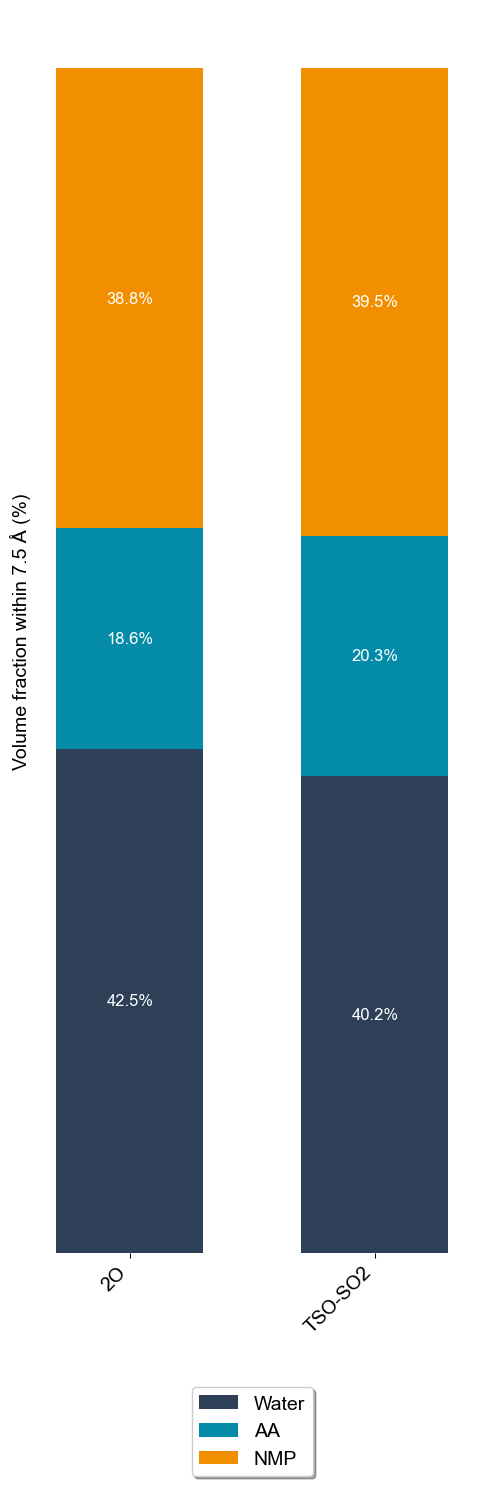

In [4]:
def plot_frac_adjusted(labels, data, colors, bar_width=0.6, figure_size=(5, 15), label_rotation=45):
    fig, ax = plt.subplots(figsize=figure_size)
    x = np.arange(len(labels))
    bottoms = np.zeros(len(labels))
    for i, (layer_name, values) in enumerate(data.items()):
        ax.bar(x,values,bar_width, bottom=bottoms, label=layer_name, color=colors[i])
        for j, val in enumerate(values):
            ax.text(
                j,
                bottoms[j] + val / 2,
                f'{val:.1f}%',
                ha='center',
                va='center',
                color='white',
                fontsize=12,
                clip_on=True
            )
        bottoms += values
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks([])
    ax.set_ylabel('Volume fraction within 7.5 Å (%)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=label_rotation, ha='right')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=1)
    plt.tight_layout()
    plt.show()

colors = ['#2e4057', '#048ba8', '#f18f01']
plot_frac_adjusted(labels, data, colors)